# BRIDGET: Dutch Census

From: https://github.com/tailequy/fairness_dataset/tree/main/Dutch_census

Paper: [A survey on datasets for fairness-aware machine learning (Tai Le Quy et al.)](https://arxiv.org/abs/2110.00530)


## Dataset Preprocessing


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
import yaml
import random
import time
import functools
import pickle
import re
import orjson
import alibi
import ignite
import copy

from IPython import display
from itertools import combinations, product
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optimizer

import fatf.utils.data.datasets as fatf_datasets
import fatf.fairness.data.measures as fatf_dfm
import fatf.utils.data.tools as fatf_data_tools

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import optim
from river import metrics
from river import feature_extraction, feature_selection
from river import ensemble, linear_model, forest, compose

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

from alibi.explainers.cfproto import CounterFactualProto

from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from bridget_mod import BRIDGET, HiC, MiC


c:\Users\virgm\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


26-Feb-09 20:36:20 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [4]:
data= pd.read_csv(r".\datasets\dutch.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60420 entries, 0 to 60419
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   sex                   60420 non-null  object
 1   age                   60420 non-null  int64 
 2   household_position    60420 non-null  int64 
 3   household_size        60420 non-null  int64 
 4   prev_residence_place  60420 non-null  int64 
 5   citizenship           60420 non-null  int64 
 6   country_birth         60420 non-null  int64 
 7   edu_level             60420 non-null  int64 
 8   economic_status       60420 non-null  int64 
 9   cur_eco_activity      60420 non-null  int64 
 10  marital_status        60420 non-null  int64 
 11  occupation            60420 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 5.5+ MB


In [5]:
data= data.drop_duplicates()

In [6]:
# encoding sex
map= {'male': 0, 'female': 1}

data['sex']= data['sex'].map(map)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18438 entries, 0 to 60413
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   sex                   18438 non-null  int64
 1   age                   18438 non-null  int64
 2   household_position    18438 non-null  int64
 3   household_size        18438 non-null  int64
 4   prev_residence_place  18438 non-null  int64
 5   citizenship           18438 non-null  int64
 6   country_birth         18438 non-null  int64
 7   edu_level             18438 non-null  int64
 8   economic_status       18438 non-null  int64
 9   cur_eco_activity      18438 non-null  int64
 10  marital_status        18438 non-null  int64
 11  occupation            18438 non-null  int64
dtypes: int64(12)
memory usage: 1.8 MB


In [7]:
data['occupation'].value_counts().sum # still almost balanced

<bound method Series.sum of occupation
0    10129
1     8309
Name: count, dtype: int64>

In [8]:
# Qui definiamo i vari split dei flussi 

data = data.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle iniziale

class_0 = data[data['occupation'] == 0]
class_1= data[data['occupation'] == 1]


def stratif(start_point, end_point):
    class_0_perc= class_0.iloc[int(len(class_0)*start_point) : int(len(class_0)*end_point)]
    class_1_perc= class_1.iloc[int(len(class_1)*start_point) : int(len(class_1)*end_point)]

    total= pd.concat([class_0_perc, class_1_perc]).sample(frac=1, random_state= 42).reset_index(drop=True)
    #chiaramente se c'è il concat bisogna rifare lo shuffle

    return total

In [9]:
#  split ufficiale

target= 'occupation'
calibration_data= stratif(0.6, 0.8)
mic_data= stratif(0.8, 1.0)

avv_train= stratif(0.0, 0.07)
avv_test= stratif(0.07, 0.1)

hic_train= stratif(0.1, 0.5)
hic_test= stratif(0.5, 0.6)

print(len(calibration_data))
print(len(mic_data))

print(len(avv_train))
print(len(avv_test))

print(len(hic_train))
print(len(hic_test))

3688
3688
1290
552
7376
1844


In [10]:
categoricals= ['sex'] # since its scaled already i wont pass it to the min max
numericals= [c for c in data if c not in categoricals and c != target]


prepr_transf = (
    (compose.Select(*numericals) | preprocessing.MinMaxScaler()) +
    compose.Select(*categoricals)
)

In [11]:
## trasformazione in df perchè servono per il logging e come lookup delle istanze (batch1 e batch3)

df_batch_1 = pd.DataFrame(hic_train).reset_index(drop=True)

df_avv= pd.concat([avv_train, avv_test]).reset_index(drop=True)
df_avv.head(n=5)


,sex,age,household_position,household_size,prev_residence_place,citizenship,country_birth,edu_level,economic_status,cur_eco_activity,marital_status,occupation
0,0,12,1140,113,1,1,1,5,111,136,2,1
1,1,8,1210,111,1,1,1,5,111,122,1,1
2,0,11,1122,113,1,1,3,3,111,132,2,0
3,1,10,1122,126,1,1,1,2,111,133,2,0
4,1,12,1122,113,1,1,1,4,111,136,2,0


In [12]:
## ora divisione in x e y

# avviamento 
X_avv_train = avv_train.drop(columns=[target])
y_avv_train = avv_train[target]

X_avv_test = avv_test.drop(columns=[target])
y_avv_test = avv_test[target]


# hic
X_hic_train = hic_train.drop(columns=[target])
y_hic_train = hic_train[target]

X_hic_test = hic_test.drop(columns=[target])
y_hic_test = hic_test[target]
# validation
X_val = calibration_data.drop(columns=[target])
y_val = calibration_data[target]

# mic
X_mic = mic_data.drop(columns=[target])
y_mic = mic_data[target]

## Calibration Phase: Experts and Incremental Model Selection

In [13]:
with open(r".\experts_dutch.yaml", "r") as f:
    config= yaml.safe_load(f)


params_dict= config['experts']['groups']['w_dict']
#feat_order= list(config['experts']['groups']['w_dict'].keys())


### Calibrating Incremental Model

The incremental model to be chosen for Bridget is trained on the X_avv, y_avv portion of the dataset,then evaluated on the X_avv_test and y_avv_test

The calibration phase starts by assessing the results of the learning for several configurations:

    - HoeffdingTreeClassifier

    - ExtremelyFastDecisionTreeClassifier

    - AdaBoostClassifier            (base= SGTClassifier)

    - AdwinBaggingClassifier        (base= SGTClassifier)

    - SRPClassifier                 (base= SGTClassifier)

    - AdaptiveRandomForestClassifier


The metrics observed are the Accuracy, the F1Score and the Counters for the classes

In [14]:
# since all River models work with dicts, lets first transform the dfs to dict
X_avv_df = pd.DataFrame(X_avv_train)
X_avv_test= pd.DataFrame(X_avv_test)

X_avv_dict= X_avv_df.to_dict(orient='records')
X_avv_dict_test= X_avv_test.to_dict(orient='records')


# setting the init params required by HIC class
RULE = False
PAST = True
SKEPT = True
GROUP = True
EVA=    True
N_BINS = 10
N_VAR = 3
MAX = 5

test_batch_1= pd.DataFrame(X_hic_test)

test_batch_1[target]= y_hic_test

rule_att = 'edu_level' # a random rule
rule_value = 0.1 # viene scalata anyways

protected= ['citizenship', 'age', 'sex']


In [15]:
# then the models are instantiated and trained by the HiC.train function
# the HiC object is initialized by passing a random user model, its not relevant since it won't interact with the IL anyways

expert= 'accurate_trusting'

base = tree.HoeffdingAdaptiveTreeClassifier(
    grace_period=200,  # Leggermente più basso per imparare prima
)


htree= tree.HoeffdingAdaptiveTreeClassifier(grace_period= 200)
efdt= tree.ExtremelyFastDecisionTreeClassifier(grace_period=200)
ada= ensemble.AdaBoostClassifier(model= base, n_models= 12, seed= 42)  
adwin= ensemble.ADWINBaggingClassifier(model= base, n_models= 8, seed= 42)
srp= ensemble.SRPClassifier(model= base, n_models=12, seed= 42)
arf= forest.ARFClassifier(n_models= 12, grace_period= 200, max_features='sqrt', seed=42)

models= [htree, efdt, ada, adwin, srp, arf]


for model in models:
    
    bridget_inst= HiC(expert, df_batch_1, mic_data, test_batch_1, target, expert, protected, categoricals, numericals,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, model,  
                0.8, 0.7, 0.0, prepr_transf)

    
    bridget_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

trained_arf= arf

Accuracy: 71.92%
F1: 63.18%
Distribution of predictions: Counter({0: 380, 1: 172})
HoeffdingAdaptiveTreeClassifier trained
Accuracy: 72.64%
F1: 68.48%
Distribution of predictions: Counter({0: 322, 1: 230})
ExtremelyFastDecisionTreeClassifier trained
Accuracy: 72.83%
F1: 68.88%
Distribution of predictions: Counter({0: 319, 1: 233})
AdaBoostClassifier(HoeffdingAdaptiveTreeClassifier) trained
Accuracy: 71.38%
F1: 62.74%
Distribution of predictions: Counter({0: 377, 1: 175})
ADWINBaggingClassifier(HoeffdingAdaptiveTreeClassifier) trained
Accuracy: 75.18%
F1: 73.29%
Distribution of predictions: Counter({0: 288, 1: 264})
SRPClassifier(HoeffdingAdaptiveTreeClassifier) trained
Accuracy: 78.80%
F1: 74.51%
Distribution of predictions: Counter({0: 342, 1: 210})
ARFClassifier trained


### Calibrating Experts

For the Adult dataset the .search_bounds function was not capable to find the bounds at all, even after doubling the search range and running 10 iters

Thus i pre-trained the IL models first, which update the scaler, then transformed the columns for the expert to be fitted on

In [16]:
#expert_data= pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X_exp= X_hic_train.to_dict(orient='records')


X_exp_scaled= []

for x in X_exp:
    X_exp_scaled.append(prepr_transf.transform_one(x))

X_exp_final = pd.DataFrame(X_exp_scaled)

In [17]:
experts_obj= {}

expert_names = ['accurate_trusting', 'accurate_not_trusting', 
                'inaccurate_trusting', 'inaccurate_not_trusting']

 #enforcing order just to make sure the column transformer didnt shuffle the col order


for name in expert_names:
    expert_type= config['experts']['groups'][name]

    experts_obj[name]= BetaUser(
        belief_level= expert_type['belief_value'],
        rethink_level= 0.3,
        fairness= True,
        fpr= expert_type['target_FPR'],
        fnr= expert_type['target_FNR'],
        alpha= 0.9,
        
        features_dict= params_dict,
        seed= expert_type['group_seed']
        )
    res = experts_obj[name].fit(X_exp_final, y_hic_train, tol= 0.001)
    print(f"{'='*30}")
    print(f" EXPERT CALIBRATION REPORT ")
    print(f"{'='*30}")

    print(f"\n[EXPERT: {name}]")
    print(f"\n[FALSE POSITIVE RATE]")
    print(f"  - Iters:      {res['fpr iters number']}")
    print(f"  - Beta:       {res['calibrated_fpr_beta']:.4f}")
    print(f"  - Target:     {res['target_fpr']}")
    print(f"  - Achieved:   {res['achieved_fpr']:.4f}")

    print(f"\n[FALSE NEGATIVE RATE]")
    print(f"  - Iters:      {res['fnr iters number']}")
    print(f"  - Beta:       {res['calibrated_fnr_beta']:.4f}")
    print(f"  - Target:     {res['target_fnr']}")
    print(f"  - Achieved:   {res['achieved_fnr']:.4f}")
    


 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      11
  - Beta:       -3.6133
  - Target:     0.05
  - Achieved:   0.0501

[FALSE NEGATIVE RATE]
  - Iters:      12
  - Beta:       -2.3926
  - Target:     0.05
  - Achieved:   0.0493
 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      12
  - Beta:       -3.3691
  - Target:     0.05
  - Achieved:   0.0491

[FALSE NEGATIVE RATE]
  - Iters:      13
  - Beta:       -2.5635
  - Target:     0.05
  - Achieved:   0.0500
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      11
  - Beta:       -1.4648
  - Target:     0.3
  - Achieved:   0.3005

[FALSE NEGATIVE RATE]
  - Iters:      13
  - Beta:       -0.3174
  - Target:     0.3
  - Achieved:   0.3004
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      15
  - Beta:       -1.4709
  - Target:     0.3
  - Achieved:   

## BRIDGET decision making

Dopo una prima run di train HIC e testing usando HoeffdingTree e una con EFDT ho deciso di provare la run con ARF, per capire se l'accuracy e F1 iniziali riuscissero a migliorarsi sostanzialmente dopo HiC

### Expert: Accurate, Trusting 

#### HiC

In [18]:
clean_prepr = copy.deepcopy(prepr_transf)

arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_trusting']
name= f"{'accurate_trusting'}"


hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, current_expert, protected, categoricals, numericals,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, arf_mod,  
                0.85, 0.7, 0.0, prepr_transf)

In [18]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

acc_t= pd.DataFrame(hic_df)

acc_t.to_csv(f".\processed_data\dutch\hic_results_ds\hic_{name}", index=False)  

#5 min w ARF, skept 0.68, drift thresh= 0.85 (too low maybe?)


100%|██████████| 7376/7376 [08:06<00:00, 15.16it/s] 


In [19]:
eval_res

[[0,
  1.0,
  0,
  0.013440506637437566,
  0.735357917570499,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0],
 [0.4329896907216495,
  0.9702970297029703,
  1,
  0.040394592619656555,
  0.7348156182212582,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  72,
  29],
 [0.205026455026455,
  0.9402985074626866,
  5,
  0.03343319936670319,
  0.7288503253796096,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  138,
  63],
 [0.15321221202472374,
  0.8266666666666667,
  7,
  0.014595055413469726,
  0.7315618221258134,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  210,
  90],
 [0.2356902356902357,
  0.765,
  11,
  -0.01119473876507121,
  0.732646420824295,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  283,
  117],
 [0.21808083511777304,
  0.7334669338677354,
  13,
  -0.035537693338204834,
  0.7331887201735358,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  363,
  135],
 [0.21765232974910395,
  0.6989966555183946,
  17,
  0.014882474729022044,
  0.7331887201735358,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  423,
  171],
 [0.20258735662843425,
  0.68194842

In [20]:
hic_inst.skept_count #none overcame the skept threshold set at 0.3

161

In [21]:
skept_list

[{'0': 0},
 {'1': 0},
 {'2': -0.054734947575758364},
 {'3': 0},
 {'4': 0},
 {'5': 0},
 {'6': 0},
 {'7': 0},
 {'8': -0.09307204509489331},
 {'9': 0.081814726658613},
 {'10': 0},
 {'11': 0.1324974148634216},
 {'12': 0},
 {'13': 0.04922632972738589},
 {'14': 0},
 {'15': 0},
 {'16': 0},
 {'17': 0},
 {'18': 0.43812339237175235},
 {'19': 0},
 {'20': 0},
 {'21': 0},
 {'22': 0},
 {'23': 0},
 {'24': 0},
 {'25': 0},
 {'26': -0.003437730928001037},
 {'27': 0},
 {'28': 0},
 {'29': 0},
 {'30': 0.041517620578609804},
 {'31': 0.2080646470153792},
 {'32': 0},
 {'33': 0.2696778029597311},
 {'34': 0},
 {'35': 0},
 {'36': 0.035440217120438766},
 {'37': 0},
 {'38': 0},
 {'39': 0},
 {'40': 0},
 {'41': 0},
 {'42': 0},
 {'43': -0.06880861188609294},
 {'44': 0},
 {'45': 0},
 {'46': 0},
 {'47': 0},
 {'48': 0},
 {'49': 0},
 {'50': -0.030040456020055062},
 {'51': 0},
 {'52': 0.04186680265531828},
 {'53': 0},
 {'54': 0.1616482400784892},
 {'55': 0.1539542316020151},
 {'56': 0},
 {'57': 0},
 {'58': 0},
 {'59': 0.2

In [19]:
# before saving the calibration and batch 3 sets, i use the same river scaler to ensure the exact scale is applied

def scale_df(data, pipe, target_c):  # a quanto pare usando questa pipeline di River la label viene persa per strada quindi la devo riattaccarre
    processed_r= []
    labels= data[target_c].values
    X = data.drop(columns=[target_c])

    for i,r in enumerate(X.to_dict(orient='records')):
        scaled_r = pipe.transform_one(r)
        scaled_r[target_c] = labels[i]
        processed_r.append(scaled_r)
    return pd.DataFrame(processed_r)

blueprint= pd.read_csv(r".\processed_data\dutch\hic_results_ds\hic_accurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]] # ridefinisco l'ordering delle feats prima delle colonne informative 

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\dutch\calibration_datasets\acc_t_calibration", index= False)


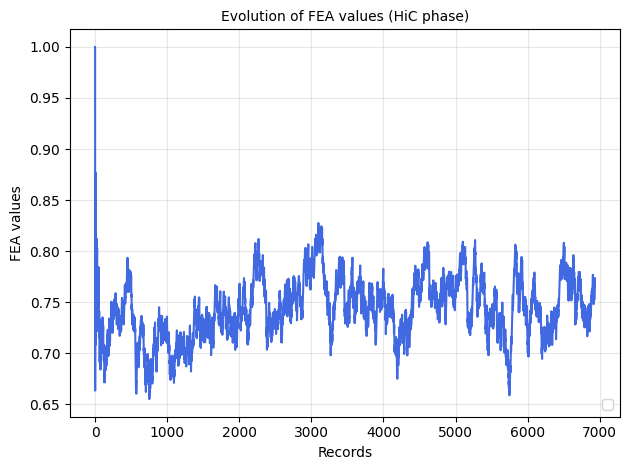

In [23]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

#### MiC

In [20]:
acc_t_switch= pd.read_csv(r".\processed_data\dutch\switch_ds\acc_t_switch")
acc_t_switch = acc_t_switch.rename(columns={'g_truth':'occupation'})

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=11, hidden_layer1=32, hidden_layer2=16, output_size=2,dropout_coeff= 0.05)  
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [21]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['occupation']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['occupation'].values, dtype= torch.long).to(device)


net_path= r".\nets\dutch\acc_t_models\32_16_acc_t_model_25.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.75

In [27]:
acc_t_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.75, clean_prepr)


acc_t_mic_df, processed,  mic_acc, model_acc, fea_mic, mach_confidence=acc_t_mic.start_MiC(X_stream, y_stream, acc_t_switch)   #3 minutes

 17%|█▋        | 615/3688 [00:00<00:01, 1545.58it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.7711264999581975, 0.7633989263301115, 0.7557489536595119, 0.7581965268015047, 0.7606195232580436]


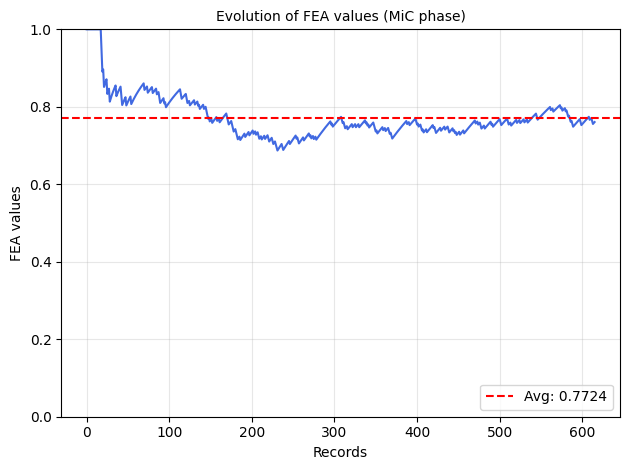

In [29]:
plt.plot(fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [30]:
print(mic_acc)
print(model_acc)
print(np.average(fea_mic))
acc_t_mic.deferred_decisions


0.8506493506493507
0.7597402597402597
0.7723942239685805


225

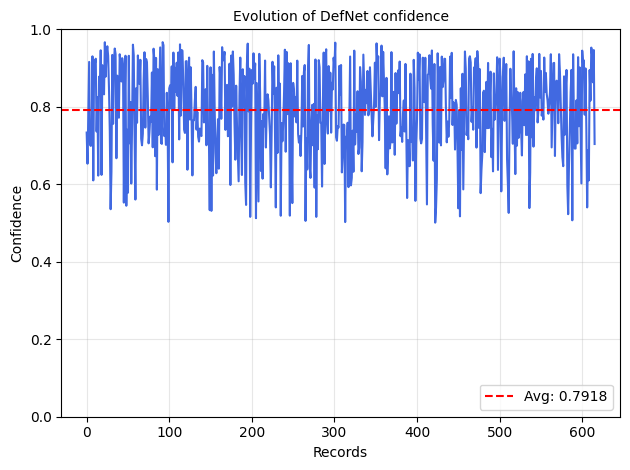

In [31]:
plt.plot(mach_confidence, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

Optimal tau= 0.230612 w/ Deferral Rate = 0.044989

In [43]:
r_net_acc_t = DeferralNet(input_size=11, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.2)

r_net_acc_t.load_state_dict(torch.load(r'r_nets/dutch/r_net_acc_t.pth'))
r_net_acc_t.to(device)
r_net_acc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [44]:
#36 min

acc_t_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.75, clean_prepr, 0.230612)


acc_t_str_2, _,  mic_acc_2, model_acc_2, fea_mic_2, mach_confidence_2=acc_t_strat_2.start_MiC(X_stream, y_stream, acc_t_switch, r_net= r_net_acc_t, two_step_deferral=True)   #3 minutes

 17%|█▋        | 615/3688 [00:00<00:02, 1077.63it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.7711264999581975, 0.7633989263301115, 0.7557489536595119, 0.7581965268015047, 0.7606195232580436]


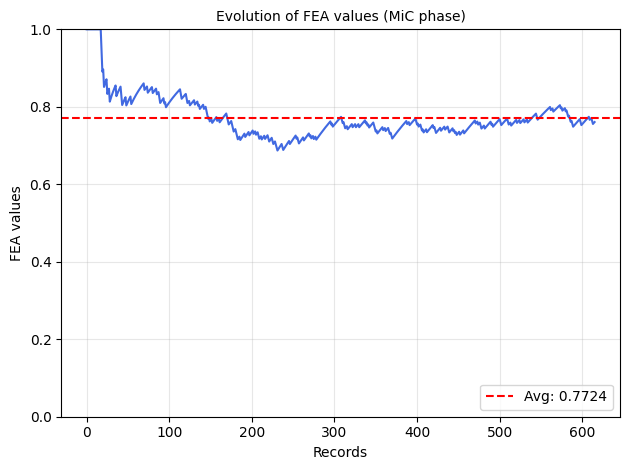

In [45]:
plt.plot(fea_mic_2, linestyle='-', color='royalblue')
avg_fea_2= np.mean(fea_mic_2)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [47]:
print(mic_acc_2)
print(model_acc_2)
print(np.average(fea_mic_2))
acc_t_strat_2.deferred_decisions


0.7711038961038961
0.7597402597402597
0.7723942239685805


27

In [48]:
acc_t_mic.stats

{False: {'user': {'tried': 98, 'got': 90, 'conf': 1},
  'machine': {'tried': 396, 'got': 251, 'conf': 0}},
 True: {'user': {'tried': 127, 'got': 122, 'conf': 1},
  'machine': {'tried': 220, 'got': 61, 'conf': 0}}}

In [49]:
acc_t_strat_2.stats

{False: {'user': {'tried': 19, 'got': 19, 'conf': 1},
  'machine': {'tried': 396, 'got': 282, 'conf': 0}},
 True: {'user': {'tried': 8, 'got': 8, 'conf': 1},
  'machine': {'tried': 220, 'got': 166, 'conf': 0}}}

### Expert: Inaccurate, Trusting 

In [24]:
def scale_df(data, pipe, target_c):  # a quanto pare usando questa pipeline di River la label viene persa per strada quindi la devo riattaccarre
    processed_r= []
    labels= data[target_c].values
    X = data.drop(columns=[target_c])

    for i,r in enumerate(X.to_dict(orient='records')):
        scaled_r = pipe.transform_one(r)
        scaled_r[target_c] = labels[i]
        processed_r.append(scaled_r)
    return pd.DataFrame(processed_r)

#### HiC

In [25]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_trusting']
name= f"{'inaccurate_trusting'}"
   

hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, current_expert, protected, categoricals, numericals,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, arf_mod,  
                0.85, 0.7, 0.0, prepr_transf) 


In [26]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

inacc_t_hic= pd.DataFrame(hic_df)

inacc_t_hic.to_csv(f".\processed_data\dutch\hic_results_ds\hic_{name}", index=False)  # 43 min

100%|██████████| 7376/7376 [07:04<00:00, 17.37it/s] 


In [27]:
eval_res

[[0,
  1.0,
  0,
  0.013440506637437566,
  0.735357917570499,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0],
 [-0.02577319587628868,
  0.6534653465346535,
  1,
  0.055184508586043124,
  0.7348156182212582,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  61,
  38],
 [0.24735449735449733,
  0.6218905472636815,
  4,
  0.02793326026062598,
  0.7250542299349241,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  118,
  81],
 [0.15396141599550478,
  0.5866666666666667,
  6,
  0.005909146267202514,
  0.7180043383947939,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  180,
  118],
 [0.31072631072631074,
  0.63,
  9,
  -0.015247838265741054,
  0.7120390455531453,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  245,
  153],
 [0.23735278372591007,
  0.6032064128256514,
  13,
  -0.025093167701863317,
  0.6963123644251626,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  297,
  199],
 [0.18019713261648745,
  0.596989966555184,
  18,
  0.06038241383509929,
  0.6767895878524945,
  0,
  2,
  2,
  0,
  0,
  0,
  2,
  349,
  243],
 [0.14963990397439314,
  0.6031

In [28]:
blueprint= pd.read_csv(r".\processed_data\dutch\hic_results_ds\hic_inaccurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\dutch\calibration_datasets\inacc_t_calibration", index= False)

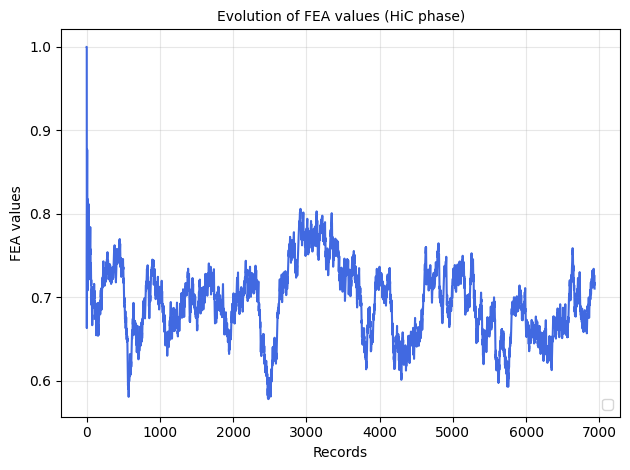

In [29]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### MiC


In [ ]:
inacc_t_switch= pd.read_csv(r".\processed_data\dutch\switch_ds\inacc_t_switch")
inacc_t_switch = inacc_t_switch.rename(columns={'g_truth':'occupation'})

In [52]:
mic_net = DeferralNet(input_size=11, hidden_layer1=32, hidden_layer2=16, output_size=2,dropout_coeff= 0.1) 
mic_net.to(device)

X_stream= torch.tensor(data= df_batch_3.drop(columns=['occupation']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['occupation'].values, dtype= torch.long).to(device)


net_path= r"nets\dutch\inacc_t_models\32_16_model_30.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence-based Deferral
Tau = 0.75

In [53]:
inacc_t_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.75, clean_prepr)


inacc_t_mic_df, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=inacc_t_mic.start_MiC(X_stream, y_stream, inacc_t_switch)   #3 minutes


 14%|█▍        | 517/3688 [00:00<00:02, 1332.75it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.7512208060993393, 0.7436659053027485, 0.7462436675116472, 0.7487953635170236, 0.7513212597714167]


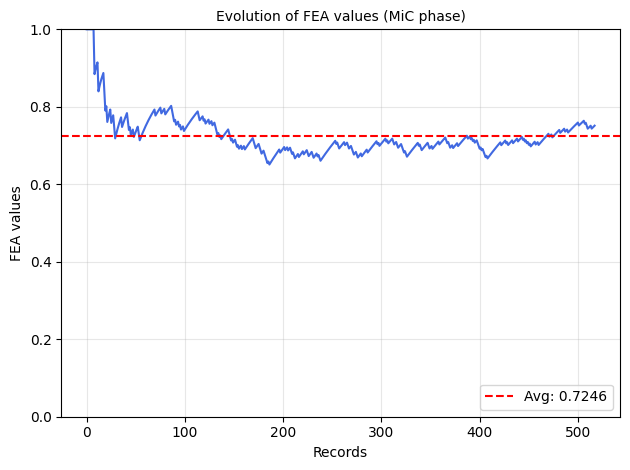

In [54]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [55]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
inacc_t_mic.deferred_decisions

0.8397683397683398
0.7200772200772201


205

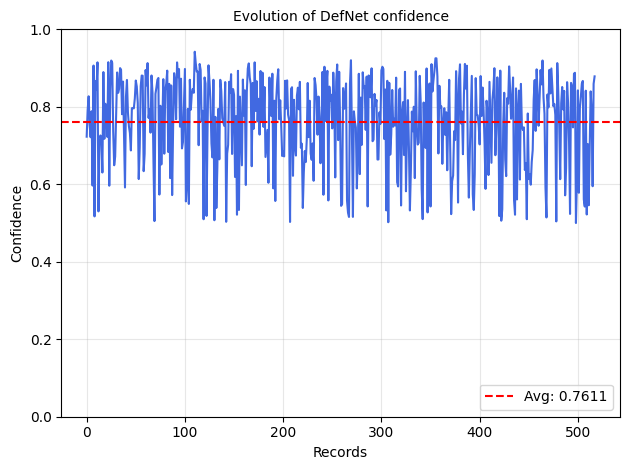

In [56]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

thresh= 0.165306 

In [57]:
r_net_inacc_t = DeferralNet(input_size=11, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.1)

r_net_inacc_t.load_state_dict(torch.load(r'r_nets\dutch\r_net_inacc_t.pth'))
r_net_inacc_t.to(device)
r_net_inacc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [58]:
inacc_t_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.75, clean_prepr, 0.165306)
 


inacc_t_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=inacc_t_strat_2.start_MiC(X_stream, y_stream, inacc_t_switch, r_net_inacc_t, two_step_deferral=True)   #3 minutes


 14%|█▍        | 517/3688 [00:00<00:02, 1130.31it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.7512208060993393, 0.7436659053027485, 0.7462436675116472, 0.7487953635170236, 0.7513212597714167]


In [59]:
print(mic_acc_3)
print(model_acc_3)
inacc_t_strat_2.deferred_decisions


0.7335907335907336
0.7200772200772201


26

### Expert: Accurate, Not Trusting

#### HIC

In [30]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_not_trusting']
name= f"{'accurate_not_trusting'}"

hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, current_expert, protected, categoricals, numericals,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, arf_mod,  
                0.85, 0.7, 0.0, prepr_transf) 


In [31]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

hic_df= pd.DataFrame(hic_df)

hic_df.to_csv(f".\processed_data\dutch\hic_results_ds\hic_{name}", index=False)  # 60 minuti

100%|██████████| 7376/7376 [08:12<00:00, 14.99it/s] 


In [32]:
blueprint= pd.read_csv(r".\processed_data\dutch\hic_results_ds\hic_accurate_not_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\dutch\calibration_datasets\acc_nt_calibration", index= False)


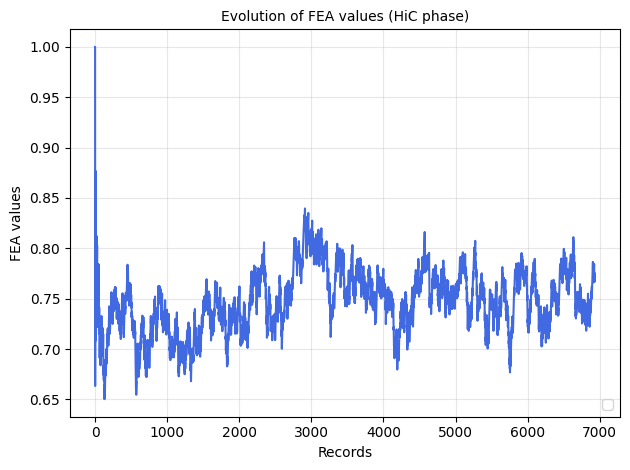

In [33]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
print(np.average(hic_feas))

0.747632370908327


#### MIC

In [60]:
acc_nt_switch= pd.read_csv(r".\processed_data\dutch\switch_ds\acc_nt_switch")
acc_nt_switch = acc_nt_switch.rename(columns={'g_truth':'occupation'})


In [61]:
mic_net = DeferralNet(input_size=11, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.1) 

X_stream= torch.tensor(data= df_batch_3.drop(columns=['occupation']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['occupation'].values, dtype= torch.long).to(device)


net_path= r"nets\dutch\acc_nt_models\32_16_acc_nt_model_19.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence Based Deferral

Tau = 0.8

In [62]:
acc_nt_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.8, clean_prepr)


acc_nt_mic_df, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=acc_nt_mic.start_MiC(X_stream, y_stream, acc_nt_switch)   #3 minutes


 20%|██        | 755/3688 [00:00<00:01, 1490.81it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.6904144140987366, 0.6935118706459902, 0.6965783207577704, 0.6996140751331293, 0.6926144245728628]


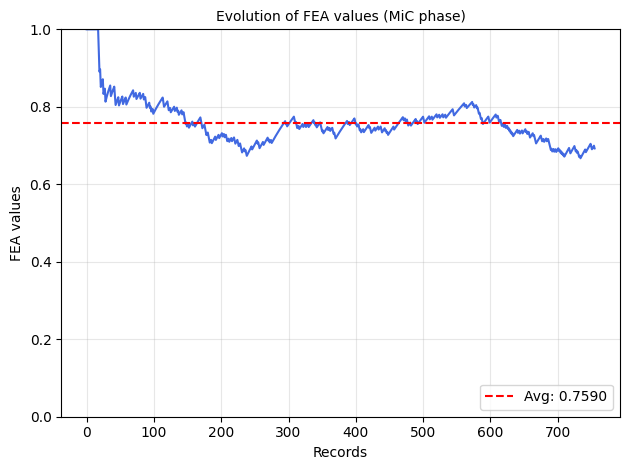

In [63]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [64]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
acc_nt_mic.deferred_decisions

0.83994708994709
0.7407407407407407


285

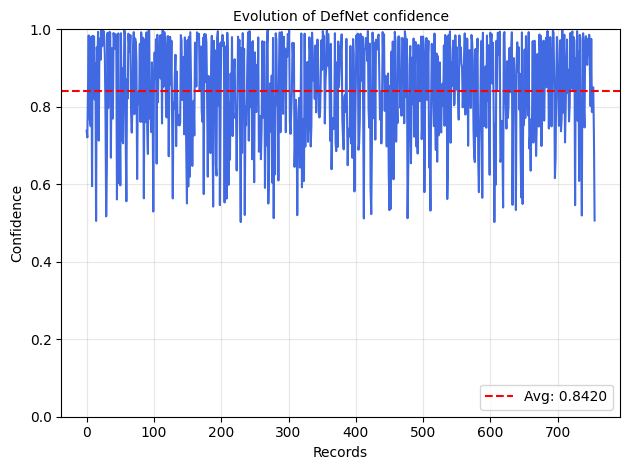

In [65]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

threshold= 0.206122 

In [67]:
r_net_acc_nt = DeferralNet(input_size=11, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.1)

r_net_acc_nt.load_state_dict(torch.load(r'r_nets\dutch\r_net_acc_nt.pth'))
r_net_acc_nt.to(device)
r_net_acc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [68]:
acc_nt_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.8, clean_prepr,0.206122 ) 


acc_nt_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=acc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net_acc_nt, two_step_deferral=True)   #3 minutes


 20%|██        | 755/3688 [00:00<00:02, 1136.09it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.6904144140987366, 0.6935118706459902, 0.6965783207577704, 0.6996140751331293, 0.6926144245728628]


In [69]:
print(mic_acc_3)
print(model_acc_3)
acc_nt_strat_2.deferred_decisions


0.7579365079365079
0.7407407407407407


61

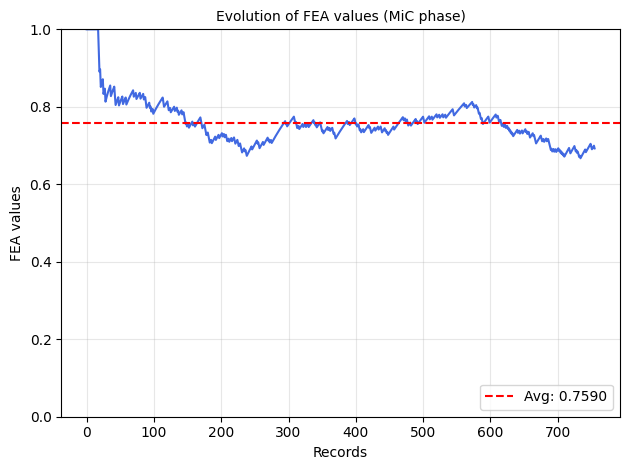

In [70]:
plt.plot(fea_mic_3, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_3)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


### Expert: Inaccurate, Not Trusting

#### HIC

In [35]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_not_trusting']
name= f"{'inaccurate_not_trusting'}"


hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, current_expert, protected, categoricals, numericals,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, arf_mod,  
                0.85, 0.7, 0.0, prepr_transf) 


In [36]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

hic_df= pd.DataFrame(hic_df)

hic_df.to_csv(f".\processed_data\dutch\hic_results_ds\hic_{name}", index=False)  # 40 minuti

100%|██████████| 7376/7376 [06:37<00:00, 18.54it/s] 


In [37]:
blueprint= pd.read_csv(r".\processed_data\dutch\hic_results_ds\hic_inaccurate_not_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\dutch\calibration_datasets\inacc_nt_calibration", index= False)


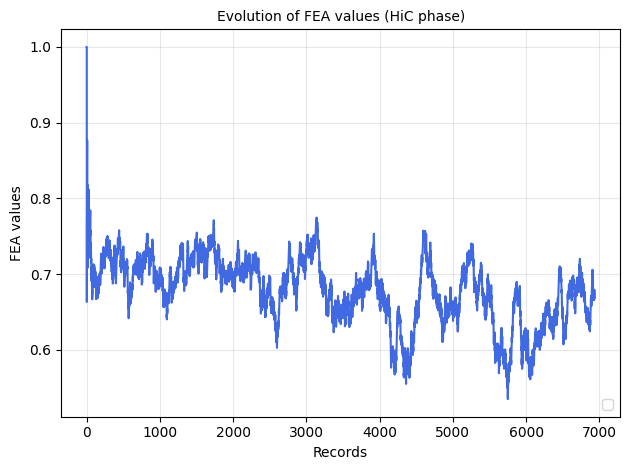

In [38]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### MIC

In [71]:
inacc_nt_switch= pd.read_csv(r".\processed_data\dutch\switch_ds\inacc_nt_switch")
inacc_nt_switch = inacc_nt_switch.rename(columns={'g_truth':'occupation'})


In [72]:
mic_net = DeferralNet(input_size=11, hidden_layer1=32, hidden_layer2=16, output_size=2,dropout_coeff= 0.1) 
mic_net.to(device)

X_stream= torch.tensor(data= df_batch_3.drop(columns=['occupation']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['occupation'].values, dtype= torch.long).to(device)


net_path= r"nets\dutch\inacc_nt_models\32_16_inacc_nt_model_30.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Deferral Strat 1

tau= 0.73


In [73]:
inacc_nt_mic_strat_1= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.73, clean_prepr)


inacc_nt_mic, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=inacc_nt_mic_strat_1.start_MiC(X_stream, y_stream, inacc_nt_switch)   #3 minutes


 14%|█▎        | 500/3688 [00:00<00:02, 1332.06it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.706062152532797, 0.7090213692723462, 0.7119505964254174, 0.7148501418753728, 0.7177203102654275]


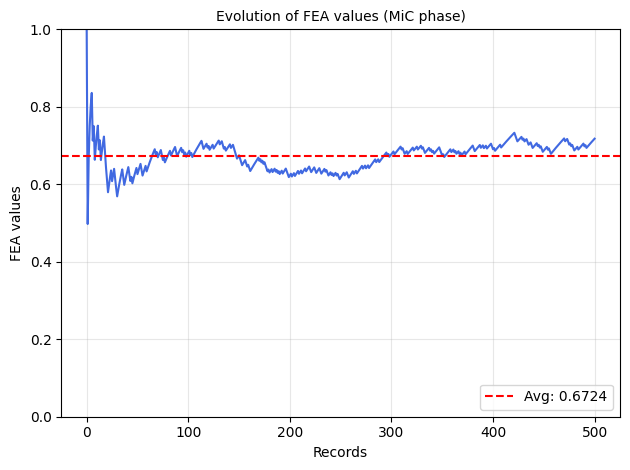

In [74]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [75]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
inacc_nt_mic_strat_1.deferred_decisions

0.8283433133732535
0.6826347305389222


194

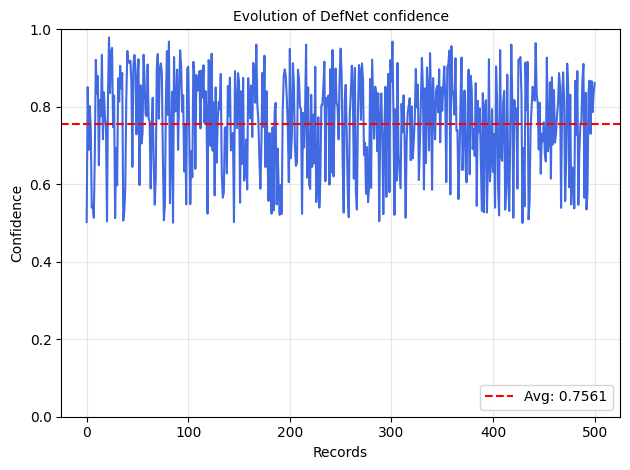

In [76]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Deferral Strat 2

anqi mao thresh= 0.173469

In [77]:
r_net_inacc_nt = DeferralNet(input_size=11, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.2)

r_net_inacc_nt.load_state_dict(torch.load(r'r_nets\dutch\r_net_inacc_nt.pth'))
r_net_inacc_nt.to(device)
r_net_inacc_nt.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [78]:
inacc_nt_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.8, clean_prepr, 0.173469)


inacc_nt_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=inacc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net_acc_nt, two_step_deferral=True)   #3 minutes


 14%|█▎        | 500/3688 [00:00<00:02, 1115.69it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.706062152532797, 0.7090213692723462, 0.7119505964254174, 0.7148501418753728, 0.7177203102654275]


In [79]:
print(mic_acc_3)
print(model_acc_3)
inacc_nt_strat_2.deferred_decisions


0.7564870259481038
0.6826347305389222


121